In [34]:

import numpy as np
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib notebook

from platipy.imaging.visualisation import vis_tools
from matplotlib.colors import hsv_to_rgb
from skimage.color import hsv2rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as mpatches

In [2]:
def returnSlice(axis, index):
    if axis == "x":
        s = (slice(None), slice(None), index)
    if axis == "y":
        s = (slice(None), index, slice(None))
    if axis == "z":
        s = (index, slice(None), slice(None))

    return s

def returnVectorFieldSlice(axis, index):
    if axis=='z':
        s = (slice(None), slice(None), index)
    if axis=='y':
        s = (slice(None), index, slice(None))
    if axis=='x':
        s = (index, slice(None), slice(None)) 
    return s

def returnVectorSlice(skipStep):
    return (slice(None, None, skipStep), slice(None, None, skipStep))

def resampleVF(axis, index, skipStep):
    if axis=='x':
        s = (slice(None, None, None),slice(None, None, skipStep), slice(None, None, skipStep))
    if axis=='y':
        s = (slice(None, None, skipStep),slice(None, None, None), slice(None, None, skipStep))
    if axis=='z':
        s = (slice(None, None, skipStep),slice(None, None, skipStep), slice(None, None, None))
    return s

def vectorImageGrid(axis, vf):
    if axis=='x':
        return np.mgrid[0:vf.shape[1]:1,0:vf.shape[0]:1]
    if axis=='y':
        return np.mgrid[0:vf.shape[2]:1,0:vf.shape[0]:1]
    if axis=='z':
        return np.mgrid[0:vf.shape[2]:1,0:vf.shape[1]:1]

# def reorientateVectorField(axis,u,v,w):
#     if axis=='x':
#         return 1.0*v,1.0*w,-1.0*u
#     if axis=='y':
#         return -1.0*u,-1.0*w,v
#     if axis=='z':
#         return -1.0*u,v,-1.0*w
    
def reorientateVectorField(axis,u,v,w):
    if axis=='x':
        return -1.0*v,-1.0*w,  1.0*u
    if axis=='y':
        return  1.0*u, 1.0*w, -1.0*v
    if axis=='z':
        return  1.0*u, 1.0*v,  1.0*w

In [17]:
image_original = sitk.ReadImage("../../1_data/NIFTI/HN1_DIR/IMAGES/HN1_DIR_0_CT_20200309.nii.gz", sitk.sitkInt16)
image_original_arr = sitk.GetArrayFromImage(image_original)

In [18]:
image_deform_synth = sitk.ReadImage("../2_output/HN1_DIR/IMAGES/HN1_DEFORM_NECK_FLEXION_FACTOR_3.nii.gz", sitk.sitkInt16)
image_deform_synth_arr = sitk.GetArrayFromImage(image_deform_synth)

In [5]:
image_deform_synth_arr_norm = (np.clip(image_deform_synth_arr, -250, 500)+250)/750
image_original_arr_norm = (np.clip(image_original_arr, -250, 500)+250)/750

arr = np.ones_like(image_deform_synth_arr_norm)

rot = 0.35 #pink-green

combined_arr_colour = np.stack([ 
                                rot*(image_deform_synth_arr_norm>image_original_arr_norm) + (0.5+rot)*(image_deform_synth_arr_norm<=image_original_arr_norm),
                                np.abs(image_deform_synth_arr_norm - image_original_arr_norm),
                                (image_deform_synth_arr_norm + image_original_arr_norm)/2
                               ], axis=-1)



In [6]:
deform_synth_field = sitk.ReadImage("../2_output/HN1_DIR/DVFS/HN1_DEFORM_NECK_FLEXION_FACTOR_3_FIELD.nii.gz")
deform_synth_field_inverse = sitk.InvertDisplacementField(deform_synth_field)

deform_rs_combined_field = sitk.ReadImage("./field_rs_combined.nii.gz")
deform_rs_combined_field_inverse = sitk.InvertDisplacementField(deform_rs_combined_field)

In [8]:
axis = "x"
cut = 256
fig_size=6
window = [-250, 500]

In [19]:
# Get all points inside the body
external = ((image_original + image_deform_synth) > 0)

mask = sitk.ConnectedComponent(external, True)

# Get the number of pixels that fall into each label map value
cts = np.bincount(sitk.GetArrayFromImage(mask).flatten())

# Keep only the largest 6 components for analysis
connected_component_values = cts.argsort()[-6:][::-1]

# Calculate metrics that describe segmentations
num_pix_list = np.zeros_like(connected_component_values, dtype=np.float32)
label_shape_analysis = sitk.LabelShapeStatisticsImageFilter()
for i, val in enumerate(connected_component_values):
    binaryVol = sitk.Equal(mask, val.astype(np.float))
    label_shape_analysis.Execute(binaryVol)
    num_pix_list[i] = label_shape_analysis.GetNumberOfPixels(True)

# Second largest volume is the body
body_value = connected_component_values[np.argsort(num_pix_list)][-2].astype(np.float)
body = sitk.Equal(mask, body_value)
body_dilate = sitk.BinaryDilate(body, 50)
body_mask = sitk.BinaryFillhole(body_dilate)

In [20]:
sitk.WriteImage(body_mask, './body_mask.nii.gz')

In [22]:
deform_rs_combined_field_mask = sitk.Mask(deform_rs_combined_field, body_mask)
deform_synth_field_inverse_mask = sitk.Mask(deform_synth_field_inverse, body_mask)

<IPython.core.display.Javascript object>


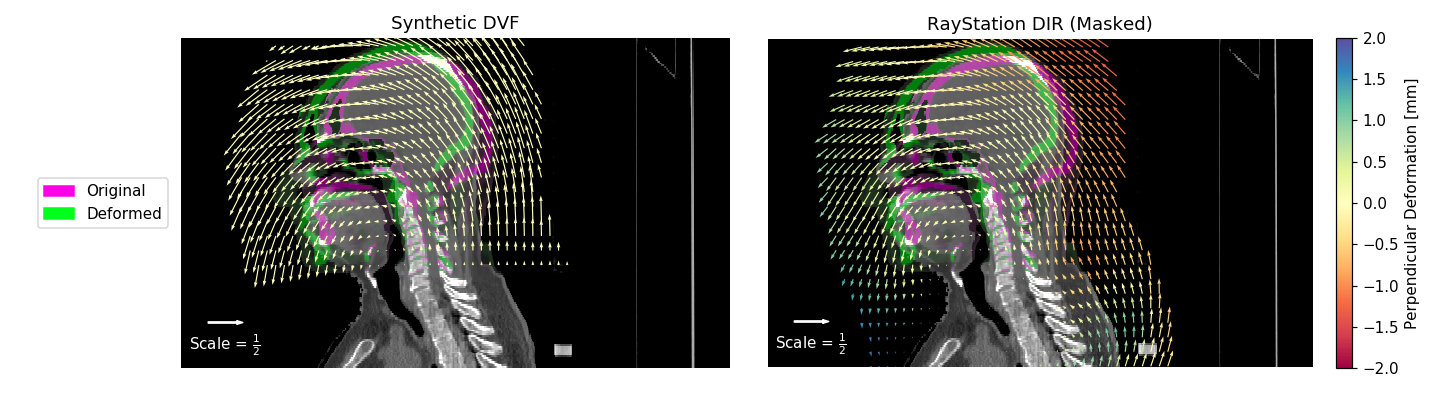

In [109]:
spPlane, _, spSlice = image_original.GetSpacing()
asp = (1.0 * spSlice) / spPlane

(AxSize, CorSize, SagSize) = image_original_arr.shape


fSize = (2*fig_size, fig_size * (asp * AxSize) / (1.0 * CorSize))
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(fSize))
org = "lower"

s = returnSlice(axis, cut)
slice_colour = hsv2rgb(combined_arr_colour.__getitem__(s))

ax1.imshow(
    slice_colour,
    aspect=asp,
    interpolation=None,
    origin=org,
)
ax2.imshow(
    slice_colour,
    aspect=asp,
    interpolation=None,
    origin=org,
)


alpha = 0.75
arrow_scale = 0.5
arrow_width = 1
skip_step = 8

nda = sitk.GetArrayFromImage(deform_rs_combined_field_mask)

u = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_rs_combined_field_mask, 0)) # x-component = u
v = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_rs_combined_field_mask, 1)) # y-component = v
w = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_rs_combined_field_mask, 2)) # z-component = w


sV = returnVectorSlice(skip_step)
plot_x_arr, plot_y_arr = vectorImageGrid(axis, nda)
plot_x, plot_y = plot_x_arr.__getitem__(sV), plot_y_arr.__getitem__(sV)
sV3D = resampleVF(axis, cut, skip_step)
c,d,e = u.T.__getitem__(sV3D), v.T.__getitem__(sV3D), w.T.__getitem__(sV3D)
sVF = returnVectorFieldSlice(axis,cut)
plot_u,plot_v,plot_w = reorientateVectorField(axis,c,d,e)


vfQ = ax1.quiver(plot_x,
                plot_y,
                plot_u.__getitem__(sVF),
                plot_v.__getitem__(sVF),
                plot_w.__getitem__(sVF),
                cmap=plt.cm.Spectral,
                units='xy',
                scale=1/arrow_scale, 
                width=arrow_width,
                clim = (-2,2),
                minlength=0,
                linewidth=1
                )

###############################################
nda = sitk.GetArrayFromImage(deform_synth_field_inverse_mask)

u = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_synth_field_inverse_mask, 0)) # x-component = u
v = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_synth_field_inverse_mask, 1)) # y-component = v
w = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_synth_field_inverse_mask, 2)) # z-component = w


sV = returnVectorSlice(skip_step)
plot_rs_x_arr, plot_rs_y_arr = vectorImageGrid(axis, nda)
plot_rs_x, plot_rs_y = plot_rs_x_arr.__getitem__(sV), plot_rs_y_arr.__getitem__(sV)
sV3D = resampleVF(axis, cut, skip_step)
c,d,e = u.T.__getitem__(sV3D), v.T.__getitem__(sV3D), w.T.__getitem__(sV3D)
sVF = returnVectorFieldSlice(axis,cut)
plot_rs_u,plot_rs_v,plot_rs_w = reorientateVectorField(axis,c,d,e)


vfQ2 = ax2.quiver(     plot_rs_x,
                plot_rs_y,
                plot_rs_u.__getitem__(sVF),
                plot_rs_v.__getitem__(sVF),
                plot_rs_w.__getitem__(sVF),
                cmap=plt.cm.Spectral,
                units='xy',
                scale=1/arrow_scale, 
                width=arrow_width,
                clim = (-2,2),
                minlength=0,
                linewidth=1
                )
###############################################


ax1.axis("off")
ax2.axis("off")

fX, fY = fig.get_size_inches()
fig.set_size_inches(fX*1.1, fY)

cbar = fig.colorbar(vfQ,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Perpendicular Deformation [mm]')

ax1.set_title('RayStation DIR (Masked)')
ax2.set_title('Synthetic DVF')


handles, labels = ax1.get_legend_handles_labels()

# manually define a new patch 
patch_o = mpatches.Patch(color=hsv_to_rgb((0.5+rot,1,1)), label='Original')
patch_d = mpatches.Patch(color=hsv_to_rgb((rot,1,1)), label='Deformed')

# handles is a list, so append manual patch
handles.append(patch_o)
handles.append(patch_d)
# plot the legend
ax2.legend(handles=handles, loc="center right", bbox_to_anchor=(-0.01, 0.5))

ax1.quiverkey(vfQ, 40, 25, 50*spPlane, 'Scale = '+ r'$\frac{1}{2}$', labelpos='S', coordinates='data', labelcolor='white', color='white', angle=0)
ax2.quiverkey(vfQ2, 40, 25, 50*spPlane, 'Scale = '+ r'$\frac{1}{2}$', labelpos='S', coordinates='data', labelcolor='white', color='white', angle=0)

fig.tight_layout()

fig.savefig("../2_output/Figures/HN1_NeckFlex_DVF_Overlay_Raystation.jpeg", dpi=300)

<IPython.core.display.Javascript object>


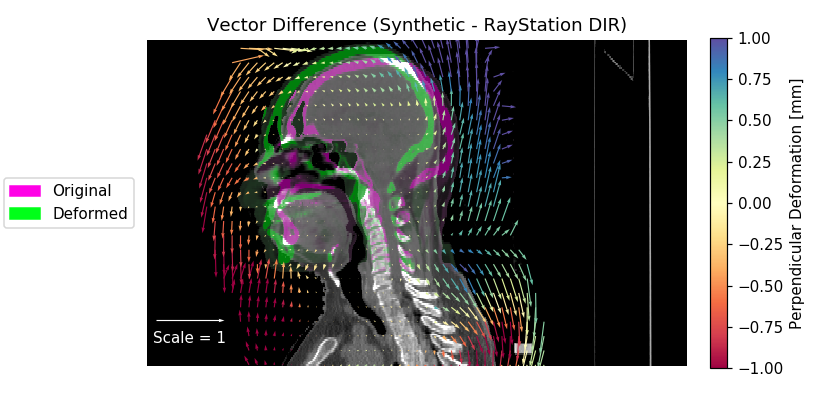

In [110]:
spPlane, _, spSlice = image_original.GetSpacing()
asp = (1.0 * spSlice) / spPlane

(AxSize, CorSize, SagSize) = image_original_arr.shape


fSize = (fig_size, fig_size * (asp * AxSize) / (1.0 * CorSize))
fig, ax = plt.subplots(1, 1, figsize=(fSize))
org = "lower"

s = returnSlice(axis, cut)
slice_colour = hsv2rgb(combined_arr_colour.__getitem__(s))

ax.imshow(
    slice_colour,
    aspect=asp,
    interpolation=None,
    origin=org,
)


alpha = 0.75
arrow_scale = 1
arrow_width = 1
skip_step = 8

nda = sitk.GetArrayFromImage(deform_synth_field_inverse_mask - deform_rs_combined_field_mask)

u = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_synth_field_inverse_mask - deform_rs_combined_field_mask, 0)) # x-component = u
v = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_synth_field_inverse_mask - deform_rs_combined_field_mask, 1)) # y-component = v
w = sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(deform_synth_field_inverse_mask - deform_rs_combined_field_mask, 2)) # z-component = w


sV = returnVectorSlice(skip_step)
plot_x_arr, plot_y_arr = vectorImageGrid(axis, nda)
plot_x, plot_y = plot_x_arr.__getitem__(sV), plot_y_arr.__getitem__(sV)
sV3D = resampleVF(axis, cut, skip_step)
c,d,e = u.T.__getitem__(sV3D), v.T.__getitem__(sV3D), w.T.__getitem__(sV3D)
sVF = returnVectorFieldSlice(axis,cut)
plot_u,plot_v,plot_w = reorientateVectorField(axis,c,d,e)


vfQ = ax.quiver(plot_x,
                plot_y,
                plot_u.__getitem__(sVF),
                plot_v.__getitem__(sVF),
                plot_w.__getitem__(sVF),
                cmap=plt.cm.Spectral,
                units='xy',
                scale=1/arrow_scale, 
                width=arrow_width,
                clim = (-1,1),
                minlength=0
                )

ax.axis('off')
fX, fY = fig.get_size_inches()
fig.set_size_inches(fX*1.25, fY)

cbar = fig.colorbar(vfQ,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Perpendicular Deformation [mm]')

ax.set_title('Vector Difference (Synthetic - RayStation DIR)')

handles, labels = ax1.get_legend_handles_labels()

# manually define a new patch 
patch_o = mpatches.Patch(color=hsv_to_rgb((0.5+rot,1,1)), label='Original')
patch_d = mpatches.Patch(color=hsv_to_rgb((rot,1,1)), label='Deformed')

# handles is a list, so append manual patch
handles.append(patch_o)
handles.append(patch_d)

# plot the legend
ax.legend(handles=handles, loc="center right", bbox_to_anchor=(-0.01, 0.5))

ax.quiverkey(vfQ, 40, 25, 50*spPlane, 'Scale = 1', labelpos='S', coordinates='data', labelcolor='white', color='white', angle=0)

fig.tight_layout()
fig.subplots_adjust(left=0.18)

fig.savefig("../2_output/Figures/HN1_NeckFlex_DVF_Overlay_Difference.jpeg", dpi=300)

In [116]:
vec_synth = sitk.GetArrayFromImage(deform_synth_field_inverse_mask)
vec_rs = sitk.GetArrayFromImage(deform_rs_combined_field_mask)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))

ax1.scatter(vec_synth[:,:,:,0], vec_rs[:,:,:,0])

<IPython.core.display.Javascript object>

In [115]:
vec_synth

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)